In [1]:
import numpy as np
import pandas as pd

In [2]:
attrs = ['AMB', 'CH4', 'CO', 'NMHC', 'NO', 'NO2',
        'NOx', 'O3', 'PM10', 'PM2.5', 'RAINFALL', 'RH',
        'SO2', 'THC', 'WD_HR', 'WIND_DIR', 'WIND_SPEED', 'WS_HR']
DAYS = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

In [677]:
def read_TrainData(filename, N):
    #N: how many hours to be as inputs
    raw_data = pd.read_csv(filename).values
    # 12 months, 20 days per month, 18 features per day. shape: (4320 , 24)
    data = raw_data[:, 3:] #first 3 columns are not data
    data = data.astype('float')
    X, Y = [], []
    for i in range(0, data.shape[0], 18*20):
        # i: start of each month
        days = np.vsplit(data[i:i+18*20], 20) # shape: 20 * (18, 24)
        concat = np.concatenate(days, axis=1) # shape: (18 feat, 480(day*hr))
        # take every N hours as x and N+1 hour as y
        for j in range(0, concat.shape[1]-N):
            features = concat[:, j:j+N].flatten() #the data of previous N hours
            features = np.append(features, [1]) # add w0
            X.append(features)
            Y.append([concat[9, j+N]]) #9th feature is PM2.5
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [678]:
#from 1/23 0am, 1am ..23pm... 2/23, 0am, .... ~ 12/31 23p.m, total 2424 hours
#will give you a matrix 2424 * (18*N features you need)
def read_TestData(filename, N):
	#only handle N <= 48(2 days)
    assert N <= 48
    raw_data = pd.read_csv(filename).values
    data = raw_data[:, 3:]
    data = data.astype('float')
    surplus = DAYS - 20 #remaining days in each month after 20th
    test_X = []
    test_Y = [] #ground truth
    for i in range(12): # 12 month
        # i: start of each month
        start = sum(surplus[:i])*18
        end = sum(surplus[:i+1])*18
        days = np.vsplit(data[start:end], surplus[i])
        concat = np.concatenate(days, axis=1) # shape: (18 feat, (day*hr))
        for j in range(48, concat.shape[1]): #every month starts from 23th
            features = concat[:, j-N:j].flatten()
            features = np.append(features, [1]) # add w0
            test_X.append(features)
            test_Y.append([concat[9, j]])
    test_X = np.array(test_X)
    test_Y = np.array(test_Y)
    return test_X, test_Y

In [575]:
# Q1: Implement Linear Regression

In [664]:
class Linear_Regression(object):
    def __init__(self, N):
        self.W = np.zeros(18*N + 1)
        self.alpha = 10e-7
    def train(self, train_X, train_Y):
        train_Y = train_Y
        error = train_Y - train_X @ self.W
        gradient = (-1.0/len(train_X)) * error @ train_X
        self.W = self.W - self.alpha * gradient
        return MSE(train_X @ self.W, train_Y)
    def predict(self, test_X):
        predict_Y = test_X.dot(self.W)
        return predict_Y

In [635]:
def MSE(predict_Y, real_Y):
    return np.square(real_Y - predict_Y).mean()

In [636]:
# Q2: Update the weight 48 times to demonstrate the pattern

In [667]:
N = 20
training_losses = []
testing_losses = []
train_X, train_Y = read_TrainData('train.csv', N=N)
model = Linear_Regression(N)
test_X, test_Y = read_TestData('test.csv', N=N)
train_Y = train_Y.squeeze()
test_Y = test_Y.squeeze()

for n in range(1000):
    training_loss = model.train(train_X, train_Y)
    predict_Y = model.predict(test_X)
    testing_loss = MSE(predict_Y, test_Y)
    training_losses.append(training_loss)
    testing_losses.append(testing_loss)

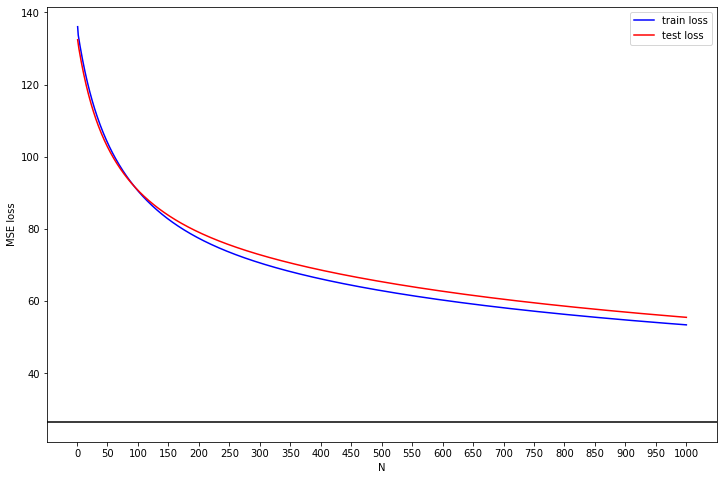

In [676]:
import matplotlib.pyplot as plt

def plotting(train_set_loss, test_set_loss):
    assert len(train_set_loss) == len(test_set_loss)
    length = len(train_set_loss)
    plt.figure(figsize=(12,8))
    plt.xticks(range(0, len(train_set_loss)+1, 50))
    plt.plot(range(1, length+1), train_set_loss, 'b', label='train loss')
    plt.plot(range(1, length+1), test_set_loss, 'r', label='test loss')
    plt.axhline(y=26.539788700003058, color='black', linestyle='-')
    plt.legend()
    plt.xlabel('N')
    plt.ylabel('MSE loss')

plotting(training_losses, testing_losses)

In [453]:
# Q3: Find the optimistic weight by formula

In [671]:
best_w = (np.linalg.inv(train_X.T @ train_X) @ train_X.T) @ train_Y

In [673]:
MSE(train_X @ best_w, train_Y)

26.539788700003058

In [674]:
MSE(test_X @ best_w, test_Y)

26.2063036925921